PyTorch i Albumentations do klasyfikacji zdjęć kotów i psów

In [1]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

# !pip install albumentations==0.4.6
# import albumentations 
# from albumentations.pytorch import ToTensorV2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

cudnn.benchmark = True

In [2]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        print("Filepath already exists. Skipping download.")
        return

    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n


def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)

In [3]:
dataset_directory = os.path.join(os.environ["HOME"], "datasets/cats-vs-dogs")

In [4]:
filepath = os.path.join(dataset_directory, "kagglecatsanddogs_3367a.zip")
download_url(
    url="https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip",
    filepath=filepath,
)
extract_archive(filepath)

kagglecatsanddogs_3367a.zip: 100%|██████████| 787M/787M [00:06<00:00, 119MB/s]


In [8]:

root_directory = os.path.join(dataset_directory, "PetImages")

cat_directory = os.path.join(root_directory, "Cat")
dog_directory = os.path.join(root_directory, "Dog")

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:20000]
val_images_filepaths = correct_images_filepaths[20000:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

20000 4936 10


In [9]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

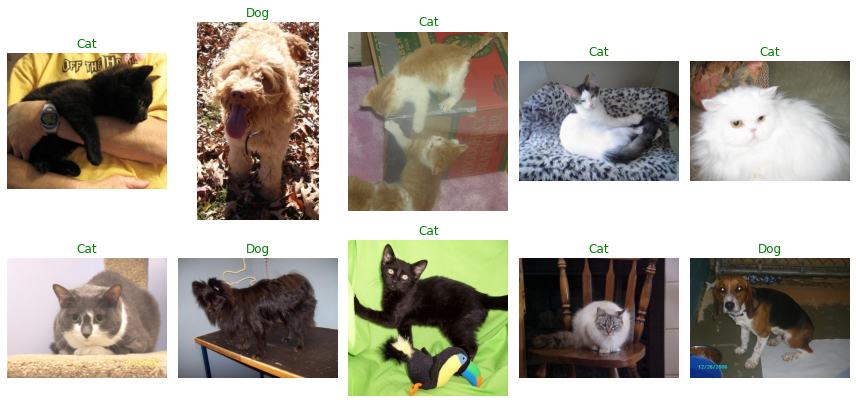

In [10]:
display_image_grid(test_images_filepaths)

In [11]:
class CatsVsDogsDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "Cat":
            label = 1.0
        else:
            label = 0.0
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [12]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = CatsVsDogsDataset(images_filepaths=train_images_filepaths, transform=train_transform)

In [13]:
val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = CatsVsDogsDataset(images_filepaths=val_images_filepaths, transform=val_transform)


In [14]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()


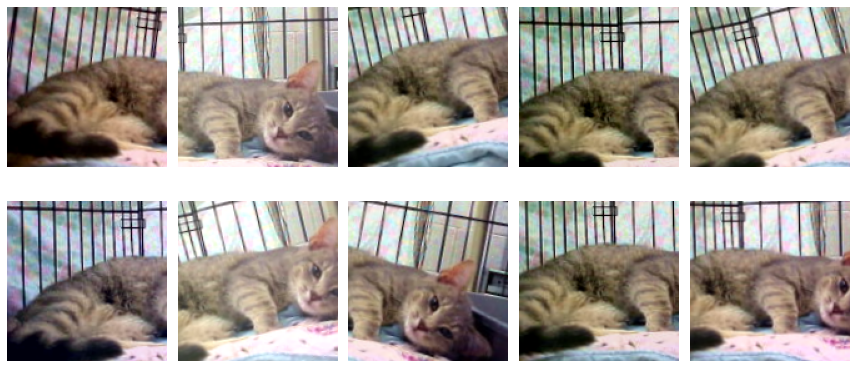

In [15]:
random.seed(42)
visualize_augmentations(train_dataset)

In [17]:
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [18]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [19]:
params = {
    "model": "resnet50",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 64,
    "num_workers": 4,
    "epochs": 10,
}

In [20]:
model = getattr(models, params["model"])(pretrained=False, num_classes=1,)
model = model.to(params["device"])
criterion = nn.BCEWithLogitsLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

In [21]:
train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)
val_loader = DataLoader(
    val_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [22]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
        output = model(images)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [23]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [24]:
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    validate(val_loader, model, criterion, epoch, params)

  0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch: 1. Train.      Loss: 0.690 | Accuracy: 0.608: 100%|██████████| 313/313 [01:15<00:00,  4.16it/s]
Epoch: 1. Validation. Loss: 0.607 | Accuracy: 0.684: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]
Epoch: 2. Train.      Loss: 0.601 | Accuracy: 0.684: 100%|██████████| 313/313 [01:15<00:00,  4.13it/s]
Epoch: 2. Validation. Loss: 0.540 | Accuracy: 0.733: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]
Epoch: 3. Train.      Loss: 0.515 | Accuracy: 0.748: 100%|██████████| 313/313 [01:15<00:00,  4.13

In [25]:
class CatsVsDogsInferenceDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image

test_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
test_dataset = CatsVsDogsInferenceDataset(images_filepaths=test_images_filepaths, transform=test_transform)
test_loader = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [26]:
model = model.eval()
predicted_labels = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(params["device"], non_blocking=True)
        output = model(images)
        predictions = (torch.sigmoid(output) >= 0.5)[:, 0].cpu().numpy()
        predicted_labels += ["Cat" if is_cat else "Dog" for is_cat in predictions]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


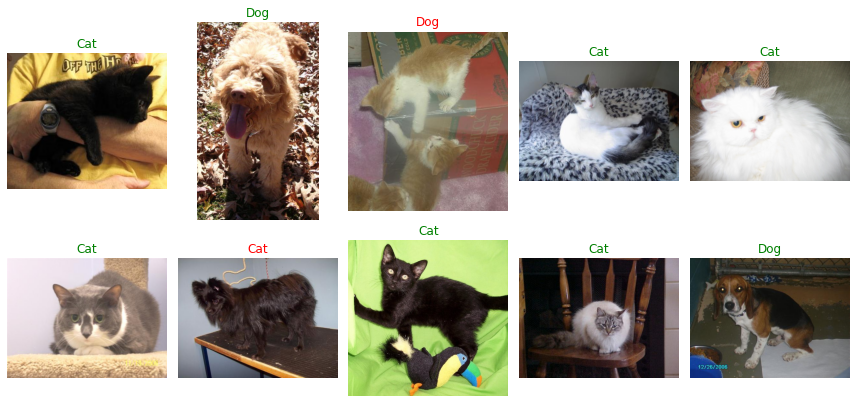

In [27]:
display_image_grid(test_images_filepaths, predicted_labels)